In [1]:
def count_parameters_conv(in_channels: int, out_channels: int, kernel_size: int, bias: bool):
    return ((in_channels * kernel_size**2 + bias) * out_channels)
    

In [3]:
count_parameters_conv(3, 9, 3, 1)

252

In [5]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

In [15]:
import os
os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ["PATH"]

In [17]:
! wget "https://static.independent.co.uk/2021/10/29/14/newFile-8.jpg?width=1200" -O peter.jpg

--2024-11-30 16:10:41--  https://static.independent.co.uk/2021/10/29/14/newFile-8.jpg?width=1200
Распознаётся static.independent.co.uk (static.independent.co.uk)… 146.75.117.91
Подключение к static.independent.co.uk (static.independent.co.uk)|146.75.117.91|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 112326 (110K) [image/jpeg]
Сохранение в: «peter.jpg»

peter.jpg           100%[===================>] 109.69K   686KB/s    за 0.2s    

2024-11-30 16:10:41 (686 KB/s) - «peter.jpg» сохранён [112326/112326]



In [19]:
img = Image.open('peter.jpg')

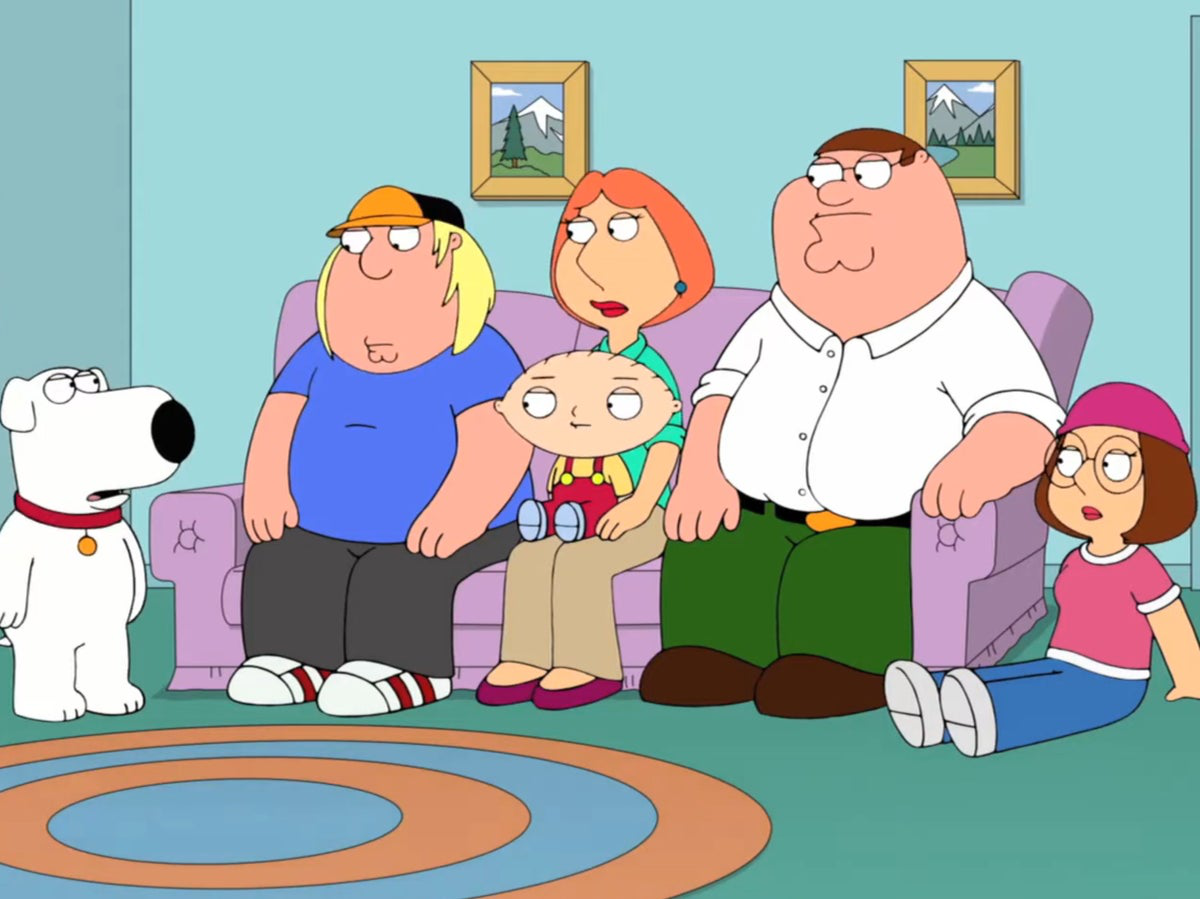

In [21]:
img

In [23]:
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.ToTensor()
)
mnist_valid = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 5088787.73it/s]


Extracting ../datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 215494.48it/s]


Extracting ../datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████| 1648877/1648877 [00:01<00:00, 1306421.08it/s]


Extracting ../datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1293666.22it/s]

Extracting ../datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/mnist/MNIST/raw



In [78]:
def train(model: nn.Module, optimizer, loss_fn, train_loader: DataLoader, device: torch.device) -> float:
    model.train()  # Переводим модель в режим обучения
    train_loss = 0
    for x, y in tqdm(train_loader, desc='Train'):
        # Перемещаем данные на GPU
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()  # Обнуляем градиенты

        output = model(x)  # Прогоняем данные через модель

        loss = loss_fn(output, y)  # Вычисляем ошибку

        train_loss += loss.item()  # Добавляем ошибку для подсчета средней

        loss.backward()  # Вычисляем градиенты

        optimizer.step()  # Обновляем параметры модели
    train_loss /= len(train_loader)  # Средняя ошибка по всем батчам
    return train_loss

In [80]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader, loss_fn, device: torch.device) -> tuple[float, float]:
    model.eval()  # Переводим модель в режим оценки

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        # Перемещаем данные на GPU
        x, y = x.to(device), y.to(device)

        output = model(x)  # Прогоняем данные через модель

        loss = loss_fn(output, y)  # Вычисляем ошибку

        total_loss += loss.item()  # Добавляем ошибку для подсчета средней

        _, y_pred = torch.max(output, 1)  # Получаем предсказания
        total += y.size(0)  # Общее количество примеров
        correct += (y_pred == y).sum().item()  # Количество правильных предсказаний

    total_loss /= len(loader)  # Средняя ошибка по всем батчам
    accuracy = correct / total  # Точность

    return total_loss, accuracy

In [82]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [43]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)

        self.ReLU =  nn.ReLU()
        self.Flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(5 * 5 * 128, 256)  # Это будет пересчитано после сверток
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, X):
        x = self.ReLU(self.conv1(X))
        x = self.pool(x)
        
        x = self.ReLU(self.conv2(x))
        x = self.pool(x)

        x = self.Flatten(x)

        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [37]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()



In [73]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, )
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

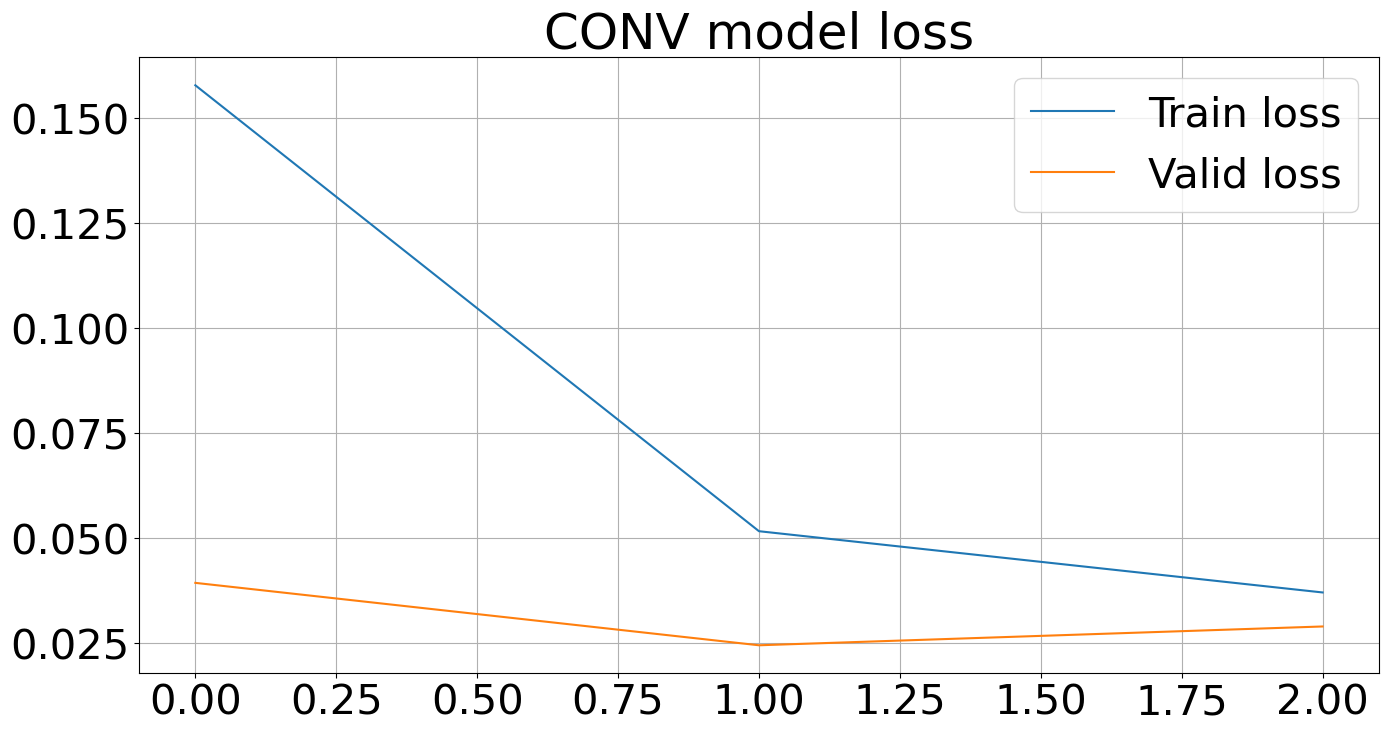

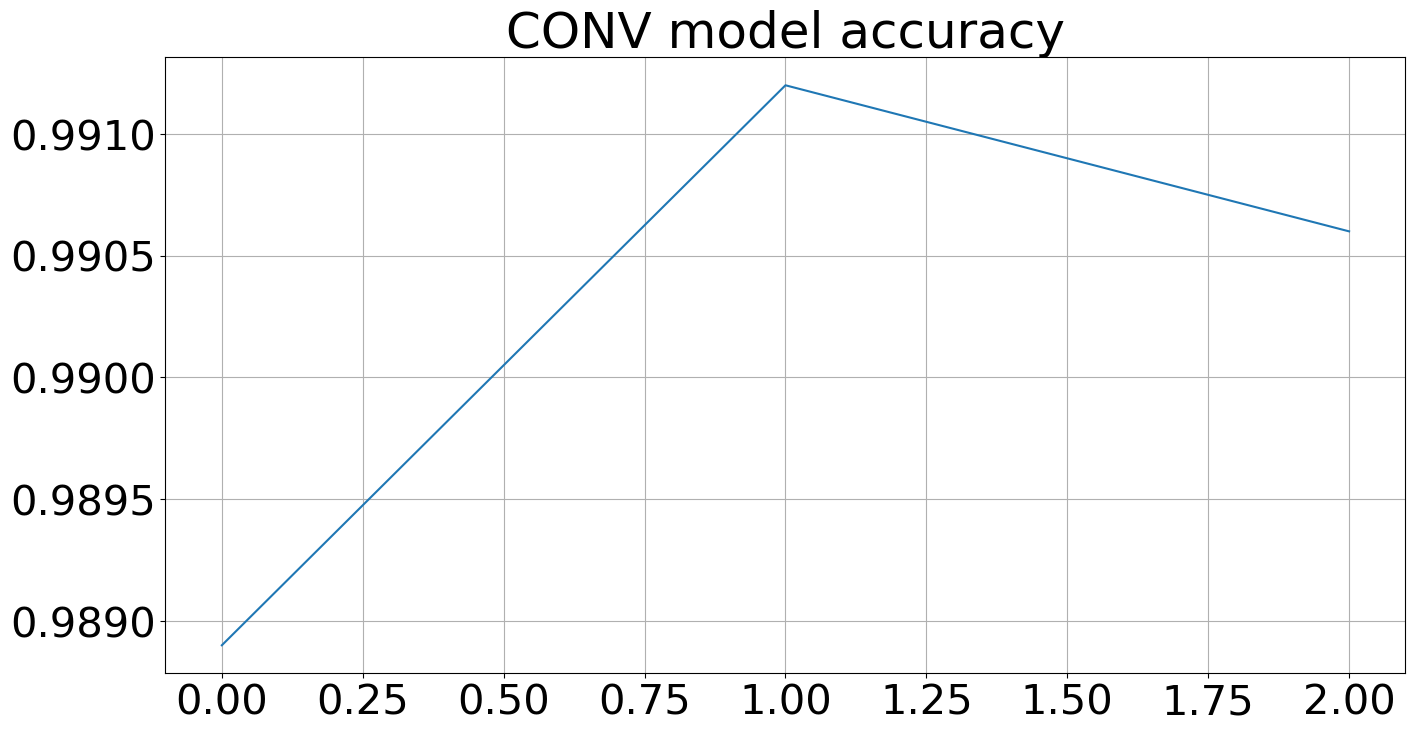

Train:  44%|██████████████▊                   | 409/938 [00:34<00:44, 11.86it/s]


KeyboardInterrupt: 

In [75]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, loss_fn, train_loader, device)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')